In [1]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv
from time import sleep
# For Progress Bar
from tqdm.notebook import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models

# from pytorch_lightning import LightningModule
# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

C:\Users\Marcous\AppData\Roaming\Python\Python39\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] 找不到指定的程序。
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

In [3]:
class LiquidDataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [4]:
class My_Model(nn.Module):
    def __init__(self, input_dim, LiquidClass):
        super(My_Model, self).__init__()
        # TODO: modify model's structure, be aware of dimensions. 
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16,LiquidClass),
            
        )

    def forward(self, x):
        x = self.layers(x)
        # x = x.squeeze(1) # (B, 1) -> (B)
        return x

In [5]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid, y_test = train_data[:,-1], valid_data[:,-1], test_data[:,-1]
    y_train.astype(int)
    y_valid.astype(int)
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data[:,:-1]

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1])) # select all feature
    else:
        feat_idx = [0,1,2,3,4] # TODO: Select suitable feature columns. 5天所有的数据
        
    # feat_idx = feat_idx[1:-1]
    print("feat_idx =",feat_idx)    
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid, y_test

In [6]:
def trainer(train_loader, valid_loader,len_train_dataset,len_valid_dataset, model, config, device):

    criterion = nn.CrossEntropyLoss() # cross entropy for classification, class start from zero

    # Define your optimization algorithm. 
    # TODO: Please check https://pytorch.org/docs/stable/optim.html to get more available algorithms.
    # TODO: L2 regularization (optimizer(weight decay...) or implement by your self).
    optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9) 

    writer = SummaryWriter() # Writer of tensoboard.

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
    best_acc = 0.0
    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        train_acc = 0.0
        train_loss = 0.0
        val_acc = 0.0
        val_loss = 0.0
        
        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            sleep(0.01)
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
            loss = criterion(pred, y.long())
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            _, train_pred = torch.max(pred, 1) # get the index of the class with the highest probability
            train_acc += (train_pred.detach() == y.detach()).sum().item()
            train_loss += loss.item()
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y.long())

            loss_record.append(loss.item())

            _, val_pred = torch.max(pred, 1) 
            val_acc += (val_pred.cpu() == y.cpu()).sum().item() # get the index of the class with the highest probability
            val_loss += loss.item()
        
        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/valid', mean_valid_loss, step)

        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                epoch + 1, n_epochs, train_acc/len_train_dataset, train_loss/len(train_loader), val_acc/len_valid_dataset, val_loss/len(valid_loader)
            ))
                    
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('saving model with acc {:.3f}'.format(best_acc/len_valid_dataset)) # 
            early_stop_count = 0
        else:
            early_stop_count += 1
        # if mean_valid_loss < best_loss:
        #     best_loss = mean_valid_loss
        #     print('Saving model with loss {:.3f}...'.format(best_loss))
        #     early_stop_count = 0
        # else: 
        #     early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 100,     # Number of epochs.            
    'batch_size': 256, 
    'learning_rate': 1e-5,              
    'early_stop': 400,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}


In [8]:
# Set seed for reproducibility
same_seed(config['seed'])


# train_data size: 2699 x 118 (id + 37 states + 16 features x 5 days) 
# test_data size: 1078 x 117 (without last day's positive rate)
# train_data, test_data = pd.read_csv('./covid.train.csv').values, pd.read_csv('./covid.test.csv').values
train_data = np.loadtxt("train_salt.txt")
test_data = np.loadtxt("test_salt.txt")

train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])

# Print out the data size.
print(f"""train_data size: {train_data.shape} 
valid_data size: {valid_data.shape} 
test_data size: {test_data.shape}""")

# Select features
x_train, x_valid, x_test, y_train, y_valid, y_test = select_feat(train_data, valid_data, test_data, config['select_all'])

# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

train_dataset, valid_dataset, test_dataset = LiquidDataset(x_train, y_train), \
                                            LiquidDataset(x_valid, y_valid), \
                                            LiquidDataset(x_test)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

# print("train_dataset shape",train_loader.shape)

train_data size: (83200, 3) 
valid_data size: (20800, 3) 
test_data size: (26000, 3)
feat_idx = [0, 1]
number of features: 2


Do training process


In [ ]:
n_class = 13 # 18 types of liquid to classify
# model = My_Model(input_dim=x_train.shape[1], LiquidClass = 18).to(device) # put your model and data on the same computation device.
model = My_Model(input_dim=3, LiquidClass = 18).to(device) # put your model and data on the same computation device.

checkpoint = torch.load('F:/liquid identification/data_base/code/models/model.ckpt')

model.load_state_dict(checkpoint)
for name, param in model.named_parameters():
    if '0' or '7' or '9' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model.layers[0] = nn.Linear(2, model.layers[0].out_features)
model.layers[9] = nn.Linear(model.layers[9].in_features, n_class)
print(model.layers)
    # print(name)
    # print(param.size())
model = model.to(device) 
trainer(train_loader, valid_loader,len(train_dataset),len(valid_dataset), model, config, device)

In [ ]:
checkpoint_ori = torch.load('F:/liquid identification/data_base/code/models/model.ckpt')
checkpoint_trans = torch.load('./models/model.ckpt')

# print(checkpoint_ori.keys())
state_dict_ori = checkpoint_ori['layers.0.weight']
state_dict_trans = checkpoint_trans['layers.0.weight']

# print(state_dict_ori)
# print(state_dict_trans)
# for name, param in state_dict_ori.items():
#     print(f'Parameter: {name}, Shape: {param.shape}')

100%|██████████| 102/102 [00:05<00:00, 17.95it/s]


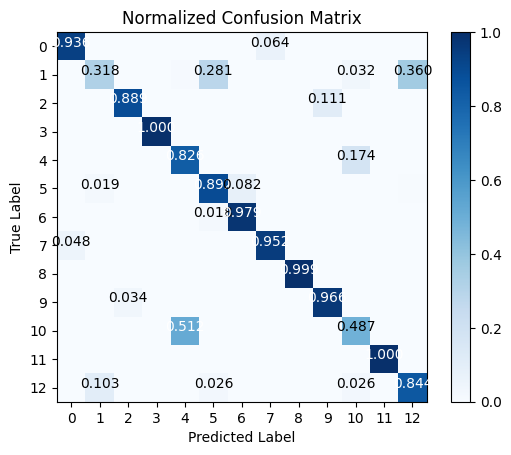

In [9]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

n_class = 13

def save_pred(preds, file):
    ''' Save predictions to specified file '''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

model = My_Model(input_dim=x_train.shape[1], LiquidClass = n_class).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)  
predicted_labels = np.argmax(preds,1)

true_labels = y_test
true_labels = np.array([int(x) for x in true_labels])
# print(preds.shape)
# print(true_labels.shape)

np.save('true_labels.npy',true_labels)
np.save('predicted_labels.npy',predicted_labels,)


cm = confusion_matrix(true_labels, predicted_labels)

# Calculate the row-wise sums
row_sums = cm.sum(axis=1)

# Normalize the confusion matrix
cm_normalized = cm / row_sums[:, np.newaxis]

# Get the class labels
classes = np.unique(true_labels)

# Plot the confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Fill the confusion matrix cells with percentage values
for i, j in np.ndindex(cm.shape):
    if cm_normalized[i, j] > 0.01:
        plt.text(j, i, format(cm_normalized[i, j], '.3f'),
                horizontalalignment="center",
                color="white" if cm_normalized[i, j] > 0.5 else "black")
    

plt.show()